# Searching in a transformed space

In the previous part of the tutorial we set up boundaries and created a method to sample from within those boundaries.
When doing this, we found it useful to replace some parameter values with their logarithm.
In this part of the tutorial we extend this log-transformation approach to the optimisation routine, so that we search in a (partly) log-transformed space.

## Why transform the search space?

Before performing parameter estimation it _can_ be a good idea to perform some kind of transformations on the search space.
For example, some optimisation methods don't perform well on spaces where the error measure varies very rapidly in one direction, but slowly in another.
In these cases it might help to rescale the parameters, e.g. so that they are all restricted to the interval $[0, 1]$.


For the "a-type" parameters in the model used in this tutorial, [Beattie et al.](https://doi.org/10.1113/JP275733) found the prior expectation was for them to vary over many orders of magnitude.
As a result, it seemed sensible to use a log-transformation on these parameters when searching, which led to notably improved results.
Further experimental confirmation of this result was provided in the supplemental results to ["Four Ways to Fit an Ion Channel Model"](https://doi.org/10.1016/j.bpj.2019.08.001), section S2.4.2.

While there is no catch-all strategy that we know of, it may be a good idea to try several transformations when dealing with a difficult parameter estimation problem.
The following section will show how.

## Implementing transformations with wrappers

In this section, we'll set up a synthetic data problem with a forward model and boundaries, and then use _wrappers_ around both to perform the log transformations.

First, we create a class that can transform points from the "model space" to the "search space" and vice versa.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import myokit
import pints

In [4]:
class LogTransform(object):
    """
    Performs forward and backward transformations on the 
    alpha-parameters used in the Beattie et al. model.    
    """
    
    def to_search(self, x):
        """Transforms from model to search space."""
        q = np.copy(x)
        q[0] = np.log(x[0])
        q[2] = np.log(x[2])
        q[4] = np.log(x[4])
        q[6] = np.log(x[6])
        return q

    def to_model(self, q):
        """Transforms from search to model space."""
        x = np.copy(q)
        x[0] = np.exp(q[0])
        x[2] = np.exp(q[2])
        x[4] = np.exp(q[4])
        x[6] = np.exp(q[6])
        return x        

Next, we define a wrapper around the forward model class and around the boundaries class.

In [5]:
class TransformedForwardModel(pints.ForwardModel):
    """
    Wraps around a ``pints.ForwardModel`` and applies parameter 
    transformations.
    """
    
    def __init__(self, model, transform):
        self._model = model
        self._transform = transform
    
    def n_parameters(self):
        return self._model.n_parameters()
    
    def simulate(self, search_parameters, times):
        model_parameters = self._transform.to_model(search_parameters)
        return self._model.simulate(model_parameters, times)

    
class TransformedBoundaries(pints.Boundaries):
    """
    Wraps around a ``pints.Boundaries`` object and applies parameter
    transformations.
    """
    def __init__(self, boundaries, transform):
        self._boundaries = boundaries
        self._transform = transform
    
    def check(self, search_parameters):
        model_parameters = self._transform.to_model(search_parameters)
        return self._boundaries.check(model_parameters)
    
    def n_parameters(self):
        return self._boundaries.n_parameters()
    
    def sample(self, n):
        model_parameters = self._boundaries.sample(n)
        search_parameters = np.zeros(model_parameters.shape)
        for i, p in enumerate(model_parameters):
            search_parameters[i] = self._transform.to_search(p)
        return search_parameters


Next, we set up an optimisation problem:

In [6]:
# Load a protocol and create a foward model instance
from library import ModelHHSolver as Model
protocol = myokit.load_protocol('resources/simplified-staircase.mmt')
model = Model(protocol)

# Define a parameter vector
parameters = np.array([3e-4, 0.07, 3e-5, 0.05, 0.09, 9e-2, 5e-3, 0.03, 0.2])

# Set up a synthetic data problem and error
times = np.arange(0, 15400, 0.1)
values = model.simulate(parameters, times)
values += np.random.normal(0, 0.025, times.shape)
problem = pints.SingleOutputProblem(model, times, values)
error = pints.MeanSquaredError(problem)

# Create boundaries and take a random sample as initial starting point
from library import Boundaries
boundaries = Boundaries()

# Make a random guess for the parameters
x0 = boundaries.sample(1)[0]

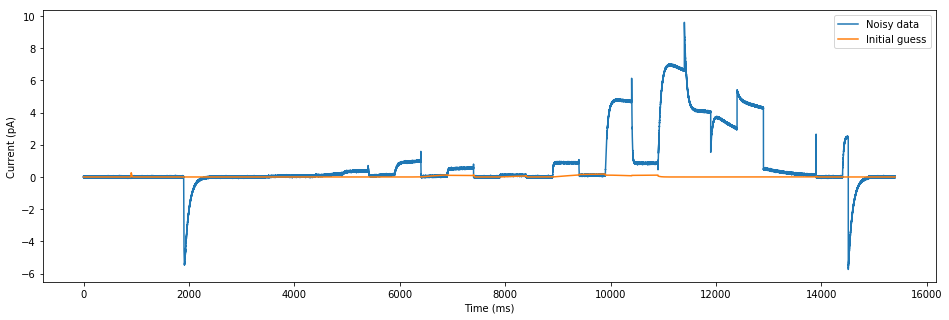

In [7]:
# Visualise the data and starting point
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, values, label='Noisy data')
plt.plot(times, problem.evaluate(x0), label='Initial guess')
plt.legend()
plt.show()

To check if it's working, we can run an evaluation with x0 and its transformed counterpart:

In [8]:
# Create the transformation object
transform = LogTransform()

# Create a transformed model and transformed boundaries
transformed_model = TransformedForwardModel(model, transform)
transformed_boundaries = TransformedBoundaries(boundaries, transform)

# Set up a problem with the transformed model
transformed_problem = pints.SingleOutputProblem(transformed_model, times, values)
transformed_error = pints.MeanSquaredError(transformed_problem)

# Create a transformed starting point
q0 = transform.to_search(x0)

print('Untransformed:')
print(x0)
print('Transformed:')
print(q0)


Untransformed:
[3.26776013e-07 2.21219577e-01 2.97739384e-04 1.08684951e-01
 2.24360696e-06 2.83863097e-01 4.98532043e-06 2.91454655e-02
 7.65599852e-01]
Transformed:
[-14.93399088   0.22121958  -8.119292     0.10868495 -13.00742574
   0.2838631  -12.20901288   0.02914547   0.76559985]


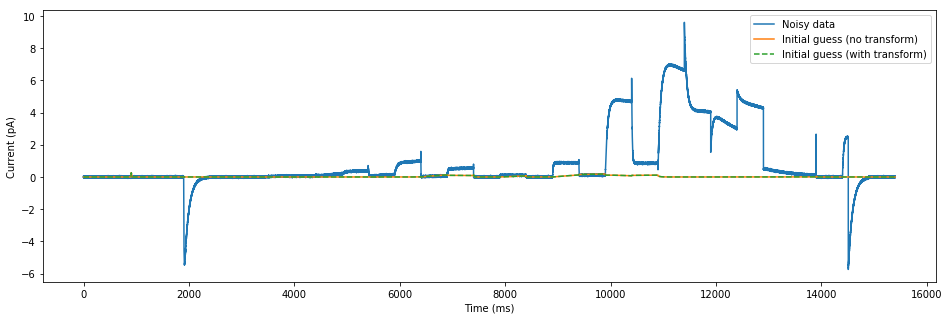

In [9]:
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, values, label='Noisy data')
plt.plot(times, problem.evaluate(x0), 
         label='Initial guess (no transform)')
plt.plot(times, transformed_problem.evaluate(q0), '--',
         label='Initial guess (with transform)')
plt.legend()
plt.show()

Now lets run an optimisation, without using log transforms:

In [17]:
opt = pints.OptimisationController(error, x0, boundaries=boundaries)
opt.set_parallel(True)
x1, f1 = opt.run()

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 4 worker processes.
Population size: 10
Iter. Eval. Best      Time m:s
0     10     59.47328   0:00.3
1     20     58.57167   0:00.5
2     30     57.47596   0:00.7
3     40     56.82963   0:00.8
20    210    30.95579   0:03.8
40    354    3.793559   0:07.7
60    490    3.147235   0:10.7
80    612    2.758719   0:14.1
100   760    2.434997   0:17.9
120   895    2.297216   0:21.6
140   1025   2.297216   0:24.7
160   1160   2.293411   0:27.2
180   1310   2.29293    0:31.0
200   1454   2.291678   0:35.0
220   1585   2.291432   0:38.6
240   1718   2.290033   0:41.8
260   1870   2.285944   0:45.3
280   2031   2.238733   0:49.8
300   2198   1.933112   0:53.5
320   2363   1.832496   0:57.0
340   2499   1.818072   1:00.0
360   2626   1.812947   1:02.7
380   2750   1.812141   1:05.3
400   2884   1.811832   1:08.1
420   3005   1.811765   1:10.8
440   3108   1.81149    1:13.2
460   3244

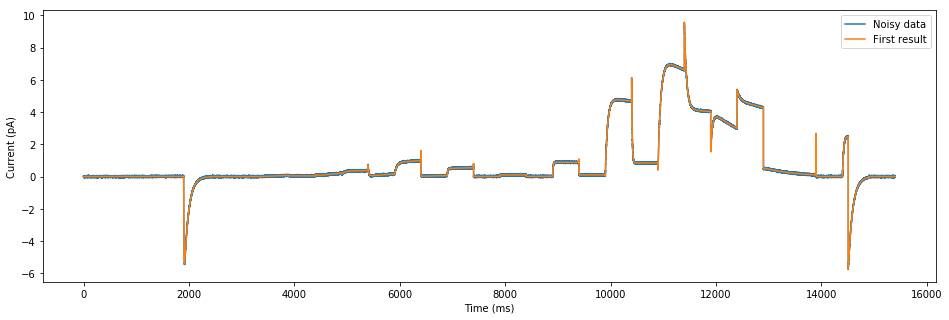

In [21]:
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, values, label='Noisy data')
plt.plot(times, problem.evaluate(x1), label='First result')
plt.legend()
plt.show()

And repeat, but this time using log-transforms on the a-type parameters:

In [19]:
# Run the optimisation
opt = pints.OptimisationController(
    transformed_error, q0, boundaries=transformed_boundaries)
opt.set_parallel(True)
q2, f2 = opt.run()

# De-transform the result
x2 = transform.to_model(q2)

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 4 worker processes.
Population size: 10
Iter. Eval. Best      Time m:s
0     9      54.56242   0:00.3
1     19     54.56242   0:00.6
2     29     51.17008   0:00.8
3     39     43.55689   0:01.1
20    147    9.370676   0:03.5
40    267    7.143412   0:06.1
60    381    6.837603   0:08.6
80    496    6.543716   0:11.1
100   605    6.497686   0:13.6
120   706    6.473057   0:16.0
140   826    6.452512   0:18.7
160   940    6.40038    0:21.2
180   1050   6.357943   0:23.6
200   1165   5.637717   0:26.2
220   1301   3.783109   0:29.1
240   1455   1.891758   0:32.3
260   1635   1.833511   0:36.0
280   1815   1.297087   0:39.6
300   1966   1.123806   0:42.6
320   2113   1.069994   0:45.9
340   2248   1.008304   0:48.9
360   2412   0.42       0:52.3
380   2536   0.184      0:55.1
400   2679   0.17       0:58.1
420   2816   0.147      1:01.0
440   2958   0.136      1:04.2
460   3140

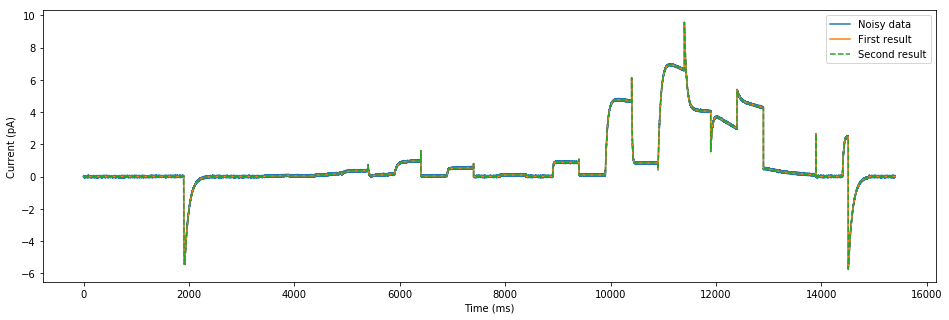

In [20]:
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, values, label='Noisy data')
plt.plot(times, problem.evaluate(x1), label='First result')
plt.plot(times, problem.evaluate(x2), '--', label='Second result')
plt.legend()
plt.show()

While there's a fair amount of stochasticity involved in every re-run, there is a good chance that the results above show the same result obtained by both optimisations, but faster (and with a lower number of total evaluations) when using the log transforms.

## Summary

In this part of the tutorial we have

- Created an object that can transform between model and search space
- Created wrappers around a [pints.ForwardModel](https://pints.readthedocs.io/en/latest/core_classes_and_methods.html#pints.ForwardModel) and [pints.Boundaries](https://pints.readthedocs.io/en/latest/boundaries.html#pints.Boundaries) object.
- Used these to run an optimisation in a transformed parameter space.

Some of the classes we've created here will be useful in further parts of the tutorial, so we've stored them in the file [library.py](library.py).

In the next part of the tutorial, we 